# TM10007 Assignment template

In [ ]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [32]:
# Data loading functions. Uncomment the one you want to use
#from worcgist.load_data import load_data
#from worclipo.load_data import load_data
#from worcliver.load_data import load_data
#from ecg.load_data import load_data
# General packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn as sns
import os

# Classifiers
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter 
from scipy.stats import shapiro
from scipy.signal import find_peaks
from sklearn.ensemble import ExtraTreesClassifier

def load_data():
    this_directory = os.getcwd()
    data = pd.read_csv(os.path.join(this_directory, 'Lipo_radiomicFeatures_with_nans.csv'), index_col=0)
    return data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Load the dataset
file_path = "data.csv"  # Ensure the dataset is in the same directory as the notebook
df = pd.read_csv(file_path)

# Display basic info and first few rows
df.info()
df.head()

The number of samples: 115
The number of columns: 494
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Columns: 495 entries, ID to PREDICT_original_phasef_phasesym_entropy_WL3_N5
dtypes: float64(468), int64(25), object(2)
memory usage: 444.9+ KB


,ID,label,PREDICT_original_sf_compactness_avg_2.5D,PREDICT_original_sf_compactness_std_2.5D,PREDICT_original_sf_rad_dist_avg_2.5D,PREDICT_original_sf_rad_dist_std_2.5D,PREDICT_original_sf_roughness_avg_2.5D,PREDICT_original_sf_roughness_std_2.5D,PREDICT_original_sf_convexity_avg_2.5D,PREDICT_original_sf_convexity_std_2.5D,...,PREDICT_original_phasef_phasesym_median_WL3_N5,PREDICT_original_phasef_phasesym_std_WL3_N5,PREDICT_original_phasef_phasesym_skewness_WL3_N5,PREDICT_original_phasef_phasesym_kurtosis_WL3_N5,PREDICT_original_phasef_phasesym_peak_WL3_N5,PREDICT_original_phasef_phasesym_peak_position_WL3_N5,PREDICT_original_phasef_phasesym_range_WL3_N5,PREDICT_original_phasef_phasesym_energy_WL3_N5,PREDICT_original_phasef_phasesym_quartile_range_WL3_N5,PREDICT_original_phasef_phasesym_entropy_WL3_N5
0,Lipo-001_0,liposarcoma,0.368434,0.262371,26.200395,8.174390,20.940000,13.551937,0.694139,0.227848,...,0.049726,0.196019,0.927821,-0.407270,0.0,0,0.625304,3238.304991,0.315148,14.462361
1,Lipo-002_0,liposarcoma,0.660571,0.179013,55.155046,9.318741,9.546044,7.051937,0.871182,0.125279,...,0.036186,0.167471,1.137972,0.411968,0.0,0,0.563659,15364.724390,0.251255,17.170274
2,Lipo-003_0,lipoma,0.365191,0.157712,30.577026,8.963647,17.695139,10.772365,0.704710,0.137529,...,0.128167,0.220546,0.829650,-0.520344,0.0,0,0.705679,3771.798158,0.369366,14.394812
3,Lipo-004_0,liposarcoma,0.372210,0.169761,94.006805,33.512409,21.049148,15.928362,0.754497,0.186559,...,0.000000,0.107987,3.130011,10.399652,0.0,0,0.438399,4707.658397,0.000000,15.733482
4,Lipo-005_0,lipoma,0.369120,0.167485,94.612701,31.250821,17.059573,15.239905,0.774545,0.192922,...,0.000000,0.087662,3.284943,11.840826,0.0,0,0.356330,6171.440113,0.000000,16.682154


## Preprocessing
### Missing values & Clean-up

In [33]:
# Check for missing values and store them
missing_values = df[df.isna().any(axis=1)]

if not missing_values.empty:
    print("Missing values stored in missing_values")
else:
    print("No missing values found")

df = df.drop(missing_values.iloc[0:,:].index)

# Encode the target variable
df['label'] = df['label'].map({'lipoma': 0, 'liposarcoma': 1})

# Drop ID column as it is not useful for training
df.drop(columns=['ID'], inplace=True)

# Display dataset after preprocessing
df.head()

# Find ratio lipoma - liposarcoma
print(f"Sick-Healthy ratio: {df['label'].sum()}-{df.shape[0]-df['label'].sum()}")


No missing values found
Sick-Healthy ratio: 58-57


### Data distribution & Scaling

In [34]:
# Check Datadistribution & Scaling
outliers = 0
not_normal_dist = 0
scaler = preprocessing.MinMaxScaler()
for column in df.columns[1:]:
    column_data = df[column].values

    # Check for normal distribution
    statistic, pvalue = shapiro(column_data)
    if float(pvalue) > 0.05:
        not_normal_dist += 1

    # Check for outliers
    Q1 = np.percentile(column_data, 25)
    Q3 = np.percentile(column_data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_count = np.sum((column_data < lower_bound) | (column_data > upper_bound))
    if outliers_count > 0:
        outliers += 1

    # Choose approprate scaler
    if not_normal_dist == 0 and outliers == 0:
        scaler = StandardScaler() 
    elif not_normal_dist != 0 and outliers == 0:
        scaler = MinMaxScaler() 
    else:
        scaler = RobustScaler()

df_label0 = df[df['label']==0]
not_normal_dist0 = 0
for column in df.columns[1:]:
    column_data = df_label0[column].values

    # Check for normal distribution
    statistic, pvalue = shapiro(column_data)
    if float(pvalue) > 0.05:
        not_normal_dist0 += 1

df_label1 = df[df['label']==1]
not_normal_dist1 = 0
for column in df.columns[1:]:
    column_data = df_label1[column].values

    # Check for normal distribution
    statistic, pvalue = shapiro(column_data)
    if float(pvalue) > 0.05:
        not_normal_dist1 += 1

df.iloc[:, 1:] = scaler.fit_transform(df.iloc[:, 1:])

print(f"Scaler used: {scaler}")
print(f"Ratio of Gaussian/NonGaussian distributions in all data: {not_normal_dist} - {df.shape[1]-not_normal_dist}")
print(f"Ratio of NoOutliers/Outliers in features in all data: {df.shape[1]-outliers} - {outliers}")

print(f"Ratio of Gaussian/NonGaussian distribution in healthy data: {not_normal_dist0} - {df_label0.shape[1]-not_normal_dist0}")
print(f"Ratio of Gaussian/NonGaussian distribution in sick data: {not_normal_dist1} - {df_label1.shape[1]-not_normal_dist1}")


/Users/liviakromopawiro/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


Scaler used: RobustScaler()
Ratio of Gaussian/NonGaussian distributions in all data: 66 - 428
Ratio of NoOutliers/Outliers in features in all data: 57 - 437
Ratio of Gaussian/NonGaussian distribution in healthy data: 117 - 377
Ratio of Gaussian/NonGaussian distribution in sick data: 86 - 408


/var/folders/vx/4c5kyxsd3z96qzr3650wtz7h0000gn/T/ipykernel_89339/538523863.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.59259259  0.07407407  0.66666667 -1.25925926  0.37037037 -0.74074074
  0.51851852 -0.07407407 -0.66666667 -0.14814815  0.14814815  0.59259259
  0.66666667  0.44444444  0.44444444 -1.11111111 -0.51851852 -0.14814815
  0.37037037 -0.44444444  0.51851852  0.2962963   0.51851852  0.22222222
  0.2962963   0.2962963  -0.2962963   0.22222222 -0.37037037 -1.48148148
  0.59259259 -0.59259259  0.22222222 -1.55555556 -2.         -0.37037037
  0.44444444  0.37037037 -0.07407407  0.37037037 -0.66666667  0.
 -1.7037037  -0.14814815  0.44444444  0.          0.37037037 -1.11111111
  0.51851852 -1.33333333  0.         -0.14814815 -0.44444444  0.07407407
 -1.18518519  0.14814815 -1.18518519  0.22222222 -1.33333333  0.
  0.37037037  0.96296296  0.59259259 -0.07407407 -0.88888889  0.66666667
 -0.59259259 

### Data split

In [35]:
# Split into train and test
X = df
y = df.iloc[:, 0]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify=y)
print(f'The number of samples in train data: {(X_train.shape[0])}')
print(f'The number of samples in test data: {(X_test.shape[0])}')

The number of samples in train data: 92
The number of samples in test data: 23


### Feature Selection
#### Variance

In [36]:
# Feature selection based on variance
variance_selector = VarianceThreshold(threshold=0.01)
data_var= variance_selector.fit_transform(X_train.iloc[:, 1:])

print(f"Features reduced from {X_train.shape[1]} to {data_var.shape[1]} features after variation filtering")

Features reduced from 494 to 467 features after variation filtering


In [37]:
# # Apply PCA based on them to explain 99% of the data
# pca = decomposition.PCA(n_components= 0.9999999999999999)
# data_pca = pca.fit_transform(data_var)

# print(f'The number of columns after variance selection: {(data_pca.shape[1])}')
# print(f'The number of rows after variance selection: {(data_pca.shape[0])}')

#### Correlation 


In [38]:
# Removing redundant features based on correlation
data_var_df = pd.DataFrame(data_var)
corr_matrix = data_var_df.corr().abs()  # Get absolute correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Drop features with correlation higher than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
data_cor = data_var_df.drop(columns=to_drop)

print(f"Features reduced from {data_var.shape[1]} to {data_cor.shape[1]} features after correlation filtering")


Features reduced from 467 to 119 features after correlation filtering


#### RFE: linear

/Users/liviakromopawiro/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liviakromopawiro/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

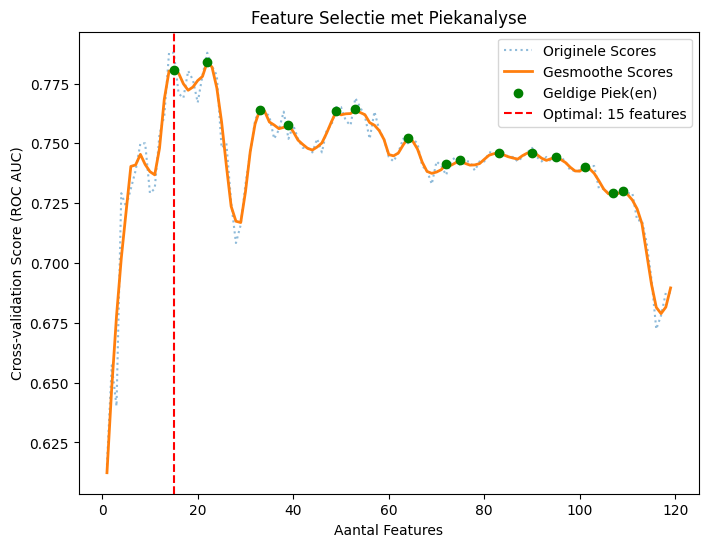

Optimale aantal features gekozen: 15


In [39]:
# Linear feature selection by RFE
est_lin = LogisticRegression(max_iter=500)

# classifications
rfecv = feature_selection.RFECV(
    estimator = est_lin, step=1,
    cv=model_selection.StratifiedKFold(4),
    scoring='roc_auc')
rfecv.fit(data_cor, y_train)

# Haal de CV-scores op
cv_scores = rfecv.cv_results_["mean_test_score"]
num_features = np.arange(1, len(cv_scores) + 1)

# Smooth de scores met Savitzky-Golay
smoothed_scores = savgol_filter(cv_scores, window_length=7, polyorder=2)  # Pas window_length aan als nodig

# Zoek pieken in de gesmoothe curve
peaks, properties = find_peaks(smoothed_scores, height=None)  # Zoekt alle pieken

# Bepaal de maximale score en de 10%-drempel
max_score = np.max(smoothed_scores)
threshold = max_score * 0.90  # 90% van de maximale score

# Filter pieken die:
# 1. Minimaal 10 features hebben
# 2. Binnen de 10% marge van de max-score zitten
valid_peaks = [p for p in peaks if num_features[p] >= 10 and smoothed_scores[p] >= threshold]

# Selecteer de eerste geschikte piek
optimal_index = valid_peaks[0] if valid_peaks else np.argmax(smoothed_scores)
optimal_features_lin = num_features[optimal_index]

# Plot de originele en gesmoothe scores
plt.figure(figsize=(8, 6))
plt.plot(num_features, cv_scores, label="Originele Scores", alpha=0.5, linestyle="dotted")
plt.plot(num_features, smoothed_scores, label="Gesmoothe Scores", linewidth=2)
plt.scatter(num_features[valid_peaks], smoothed_scores[valid_peaks], color='g', label="Geldige Piek(en)", zorder=3)
plt.axvline(optimal_features_lin, color='r', linestyle="--", label=f"Optimal: {optimal_features_lin} features")
plt.xlabel("Aantal Features")
plt.ylabel("Cross-validation Score (ROC AUC)")
plt.legend()
plt.title("Feature Selectie met Piekanalyse")
plt.show()

print(f"Optimale aantal features gekozen: {optimal_features_lin}")


#### RFE: non-linear


In [42]:
# Feature selection by RFE
from lightgbm import LGBMClassifier

est_lgbm = LGBMClassifier(n_estimators=50, learning_rate=0.1, random_state=42)

# classifications
rfecv = feature_selection.RFECV(
    estimator = est_nl, step=1,
    cv=model_selection.StratifiedKFold(4),
    scoring='roc_auc')
rfecv.fit(data_cor, y_train)

# Haal de CV-scores op
cv_scores = rfecv.cv_results_["mean_test_score"]
num_features = np.arange(1, len(cv_scores) + 1)

# Smooth de scores met Savitzky-Golay
smoothed_scores = savgol_filter(cv_scores, window_length=7, polyorder=2)  # Pas window_length aan als nodig

# Zoek pieken in de gesmoothe curve
peaks, properties = find_peaks(smoothed_scores, height=None)  # Zoekt alle pieken

# Bepaal de maximale score en de 10%-drempel
max_score = np.max(smoothed_scores)
threshold = max_score * 0.90  # 90% van de maximale score

# Filter pieken die:
# 1. Minimaal 10 features hebben
# 2. Binnen de 10% marge van de max-score zitten
valid_peaks = [p for p in peaks if num_features[p] >= 10 and smoothed_scores[p] >= threshold]

# Selecteer de eerste geschikte piek
optimal_index = valid_peaks[0] if valid_peaks else np.argmax(smoothed_scores)
optimal_features_nl = num_features[optimal_index]

# Plot de originele en gesmoothe scores
plt.figure(figsize=(8, 6))
plt.plot(num_features, cv_scores, label="Originele Scores", alpha=0.5, linestyle="dotted")
plt.plot(num_features, smoothed_scores, label="Gesmoothe Scores", linewidth=2)
plt.scatter(num_features[valid_peaks], smoothed_scores[valid_peaks], color='g', label="Geldige Piek(en)", zorder=3)
plt.axvline(optimal_features_nl, color='r', linestyle="--", label=f"Optimal: {optimal_features_nl} features")
plt.xlabel("Aantal Features")
plt.ylabel("Cross-validation Score (ROC AUC)")
plt.legend()
plt.title("Feature Selectie met Piekanalyse")
plt.show()

print(f"Optimale aantal features gekozen: {optimal_features_nl}")

OSError: dlopen(/Users/liviakromopawiro/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/lightgbm/lib/lib_lightgbm.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib
  Referenced from: <8FC36893-94B8-343C-9D9F-4CCBFE81B89B> /Users/liviakromopawiro/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/lightgbm/lib/lib_lightgbm.dylib
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/local/lib/libomp/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/local/lib/libomp/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/local/lib/libomp/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/local/lib/libomp/libomp.dylib' (no such file), '/Users/liviakromopawiro/opt/anaconda3/envs/myenv/lib/python3.12/lib-dynload/../../libomp.dylib' (no such file), '/Users/liviakromopawiro/opt/anaconda3/envs/myenv/bin/../lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file, not in dyld cache)

In [ ]:
# Feature selection with Random Forest
randomforest =  RandomForestClassifier(n_estimators = 100, random_state=42)
randomforest.fit(X_train, y_train)

feature_importance = randomforest.feature_importances_

n_importance = optimal_features
important_features = sorted(range(len(feature_importance)), key=lambda i: feature_importance[i], reverse=True)[:n_importance]

print(important_features)

print(f"Most important features (indices): {important_features}")
print(f"Feature importances: {feature_importance[important_features]}")

In [ ]:
# Check for missing values in test data
missing_values = missing_values.dropna(subset=important_features)
print(missing_values)
y_missing = missing_values.loc[X_test.index]